# estimate blackout deaths

In [1]:
%pylab inline
import pandas as pd
import xarray as xr
from scipy import interpolate
import pickle

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
## Function to load and process temperature data from CSV files
# 1. Loads a CSV file
# 2. Converts the second column to datetime and sets it as the index
# 3. Converts the third column to float, handling any non-numeric values
# 4. Calculates the daily average of the temperature data
# 5. Returns the processed temperature data as a pandas Series
def load_and_process_csv(file_path):
    # Load the CSV file, ignoring the first column
    df = pd.read_csv(file_path, usecols=[1, 2], parse_dates=[0], index_col=0)

    # Convert the temperature column to float, handling non-numeric values
    df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce')

    # Calculate the daily average of the data
    daily_average = df.resample('D').mean()

    # Rename the index to 'date'
    daily_average.index.name = 'date'

    daily_average = daily_average.iloc[:, 0]
    daily_average.name = 'tmpc'
    return daily_average

## load the temperatures of Houston and Chicago
iah = load_and_process_csv('iah.csv')
chi = load_and_process_csv('ord.csv')
sea = load_and_process_csv('sea.csv')
phx = load_and_process_csv('phx.csv')

# Merge iah, chi, sea, and phx into a single dataframe using the datetime index
temperatures = pd.merge(
    pd.merge(
        pd.merge(
            iah.to_frame(name='iah_temp'),
            chi.to_frame(name='chi_temp'),
            left_index=True, right_index=True, how='outer'
        ),
        sea.to_frame(name='sea_temp'),
        left_index=True, right_index=True, how='outer'
    ),
    phx.to_frame(name='phx_temp'),
    left_index=True, right_index=True, how='outer'
)

# Rename the columns to 'houston', 'chicago', 'seattle', and 'phoenix'
temperatures = temperatures.rename(columns={
    'iah_temp': 'houston',
    'chi_temp': 'chicago',
    'sea_temp': 'seattle',
    'phx_temp': 'phoenix'
})

/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_62784/1507606088.py:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=[1, 2], parse_dates=[0], index_col=0)


In [3]:
## This cell generates the statistics needed for the Shindell RR curve parameterization
# Calculate 84th percentile (OT) and summer mean temperature (SMT) for Houston and Chicago
ot = temperatures[['houston', 'chicago', 'seattle', 'phoenix']].quantile(0.84)
smt = temperatures[['houston', 'chicago', 'seattle', 'phoenix']][temperatures.index.month.isin([6,7,8])].mean()

# Create a new dataframe with rows for Houston and Chicago, columns for OT and SMT
climate_stats = pd.DataFrame({
    'ot': ot,
    'smt': smt
})

print(climate_stats)

                ot        smt
houston  28.550681  28.595174
chicago   22.84935  22.769819
seattle   18.35625  18.685461
phoenix  34.751339  34.902902


In [4]:
## define the rr curve function
def rr_curve(x, t):
    """create a parameterized rr curve using the recipe from Shindell et al. 2020
    assumes that climate_stats is defined with 'smt' and 'ot' columns"""
    rr = 1 - 0.0014*(climate_stats.loc[x, 'smt'] - 30.9)*(t-climate_stats.loc[x, 'ot'])**2 + 0.005*(climate_stats.loc[x, 'smt'] - 26.7)*(t-climate_stats.loc[x, 'ot'])
    rr[rr < 1] = 1
    return rr

In [5]:
def calc_heat_deaths(city, temperature):
    """given a city and the temperatures, return the 
    heat-related deaths.  return zero if temperature is
    below the OT for that city"""

    rr = rr_curve(city, temperature)
    heatDeaths = (rr - 1) * mmtDeaths
    heatDeaths[temperature < climate_stats.loc[city, 'ot']] = 0
    return heatDeaths

## calculate deaths due to heat

In [12]:
# totalPop = 7_510_253 # Houston metropolitan area
# dailyDeathsPer100k = 2.3
# mmtDeaths = totalPop/1e5*dailyDeathsPer100k
# print(f'baseline mortality per day: {mmtDeaths:.0f}')

## mmtDeaths depends on what you count as the base population
## From Texas Tribune data
mmtDeaths = 84 ## this is the number of deaths at the optimal temperature (OT)

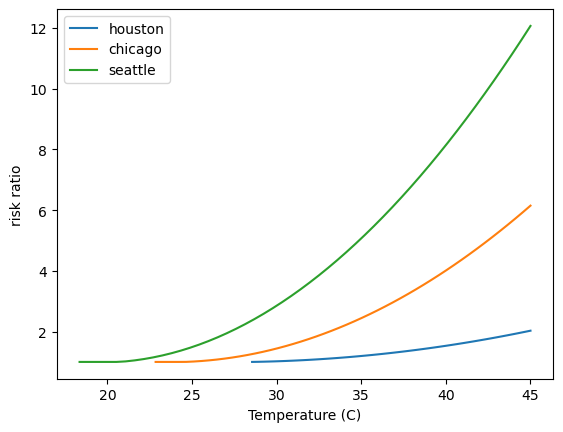

In [10]:
## plot the RR curve for Houston and Chicago
for ii in 'houston chicago seattle'.split():
    x = np.linspace(climate_stats.loc[ii, 'ot'], 45)
    plot(x, rr_curve(ii, x), label = ii)
plt.legend()
plt.xlabel('Temperature (C)')
plt.ylabel('risk ratio')
plt.savefig('rr_curve.jpg',dpi=300)
plt.show()

## Beryl deaths
We'll now calculate the deaths resulting from the power outage caused by Hurricane Beryl.  To do this, we'll first estimate deaths using Houston's risk ratio (RR) curve under normal conditions.  Then, we'll replace Houston's RR curve with those of Chicago and Seattle, under the assumption
that Houston without power might resemble the conditions in these other cities.  The difference between the deaths estimated with Chicago or Seattle and Houston is an estimate of the additional deaths caused by the power outage.

In [39]:
# Define the date range for Hurricane Beryl
dates_beryl = pd.date_range(start='2024-07-09', end='2024-07-13')

## Calculate heat-related deaths for different scenarios
# powerOn: Deaths in Houston with normal power conditions
# powerOff: Deaths in Houston if it had Seattle's heat vulnerability (simulating power outage)
# powerOff2: Deaths in Houston if it had Chicago's heat vulnerability (simulating power outage)
powerOn = calc_heat_deaths('houston', temperatures['houston']).loc[dates_beryl]
powerOff = calc_heat_deaths('seattle', temperatures['houston']).loc[dates_beryl]
powerOff2 = calc_heat_deaths('chicago', temperatures['houston']).loc[dates_beryl]

total_deaths = pd.DataFrame()
total_deaths['Temperature'] = temperatures['houston'].loc[dates_beryl]
total_deaths['Houston'] = powerOn
total_deaths['Seattle'] = powerOff
total_deaths['Chicago'] = powerOff2
# print(total_deaths.applymap(lambda x: format(x, ".1f")))
# print()

# Difference between powerOn and powerOff is 
# an estimate of the additional deaths caused by the power outage
beryl_deaths = pd.DataFrame()
beryl_deaths['Temperature'] = temperatures['houston'].loc[dates_beryl]
beryl_deaths['Seattle - Houston'] = powerOff - powerOn
beryl_deaths['Chicago - Houston'] = powerOff2 - powerOn
beryl_deaths.columns = beryl_deaths.columns.str.title()

## print out neat table
# Format numbers to one decimal place
formatted_beryl_deaths = beryl_deaths.applymap(lambda x: format(x, ".1f"))

# Add the date column
formatted_beryl_deaths['Date'] = beryl_deaths.index.strftime('%Y-%m-%d')

# Reorder columns to put Date first
columns_order = ['Date', 'Temperature', 'Seattle - Houston', 'Chicago - Houston']
formatted_beryl_deaths = formatted_beryl_deaths[columns_order]

# Get the maximum width of each column (including the header)
col_widths = [max(len(col), formatted_beryl_deaths[col].str.len().max()) for col in formatted_beryl_deaths.columns]

# Print the header
header = "  ".join(col.center(width) for col, width in zip(formatted_beryl_deaths.columns, col_widths))
print(header)

# Print the formatted and centered data
for _, row in formatted_beryl_deaths.iterrows():
    centered_row = "  ".join(val.center(width) for val, width in zip(row, col_widths))
    print(centered_row)

   Date     Temperature  Seattle - Houston  Chicago - Houston
2024-07-09      28.6           138.1               26.2      
2024-07-10      29.4           162.5               34.6      
2024-07-11      27.7           111.8               17.2      
2024-07-12      25.9            67.1               4.6       
2024-07-13      26.4            78.7               7.4       


/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_62784/2543930757.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_beryl_deaths = beryl_deaths.applymap(lambda x: format(x, ".1f"))


To estimating the impacts of power outage, we assume that power is entirely out for two days, then out for 50% of the people in the next 3 days.

In [24]:
# Sum the first two rows of beryl_deaths
first_two_sum = beryl_deaths.iloc[:2].sum()

# Add half of the next three rows
next_three_half_sum = beryl_deaths.iloc[2:5].sum() / 2

# Calculate the total
total_deaths = first_two_sum + next_three_half_sum
total_deaths = total_deaths.drop('Temperature', axis=0)

print(f"Estimated additional deaths due to power outage:")
print(total_deaths)

Estimated additional deaths due to power outage:
    Seattle - Houston    360.650691
Chicago - Houston         63.413839
dtype: object


# Recalculating for the very hot period from the WaPo article

It turns out that Houston was not particularly hot in the few days after Barrel. In this section, we'll redo our calculations using the very hot period mentioned in the Washington Post article. This analysis simulates what could happen if we were unlucky and the power outage coincided with an extremely hot period.

In [44]:
## from the WaPo article, this is the period they focus on
dates_hot = pd.date_range(start='2011-08-07', end='2011-08-11')

In [45]:
powerOn = calc_heat_deaths('houston',temperatures['houston']).loc[dates_hot]
powerOff = calc_heat_deaths('seattle',temperatures['houston']).loc[dates_hot]
powerOff2 = calc_heat_deaths('chicago',temperatures['houston']).loc[dates_hot]

# Combine powerOn and powerOff into a single dataframe
beryl_deaths = pd.DataFrame()
beryl_deaths['Temperature'] = temperatures['houston'].loc[dates_hot]
beryl_deaths['Seattle - Houston'] = powerOff - powerOn
beryl_deaths['Chicago - Houston'] = powerOff2 - powerOn

# Print the updated dataframe
# Format numbers to one decimal place
formatted_beryl_deaths = beryl_deaths.applymap(lambda x: format(x, ".1f"))

# Add the date column
formatted_beryl_deaths['Date'] = beryl_deaths.index.strftime('%Y-%m-%d')

# Reorder columns to put Date first
columns_order = ['Date', 'Temperature', 'Seattle - Houston', 'Chicago - Houston']
formatted_beryl_deaths = formatted_beryl_deaths[columns_order]

# Get the maximum width of each column (including the header)
col_widths = [max(len(col), formatted_beryl_deaths[col].str.len().max()) for col in formatted_beryl_deaths.columns]

# Print the header
header = "  ".join(col.center(width) for col, width in zip(formatted_beryl_deaths.columns, col_widths))
print(header)

# Print the formatted and centered data
for _, row in formatted_beryl_deaths.iterrows():
    centered_row = "  ".join(val.center(width) for val, width in zip(row, col_widths))
    print(centered_row)

   Date     Temperature  Seattle - Houston  Chicago - Houston
2011-08-07      31.6           240.8               64.0      
2011-08-08      31.6           240.1               63.7      
2011-08-09      32.0           258.4               71.0      
2011-08-10      31.8           249.8               67.5      
2011-08-11      32.0           256.5               70.2      


/var/folders/hp/g2_ld8qx627b8pyd2ph0qvf00000gr/T/ipykernel_62784/285653389.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_beryl_deaths = beryl_deaths.applymap(lambda x: format(x, ".1f"))


In [46]:
# Sum the first two rows of beryl_deaths
first_two_sum = beryl_deaths.iloc[:2].sum()

# Add half of the next three rows
next_three_half_sum = beryl_deaths.iloc[2:5].sum() / 2

# Calculate the total
total_deaths = first_two_sum + next_three_half_sum

# Drop the 'Temperature' row
total_deaths = total_deaths.drop('Temperature')

print(f"Estimated additional deaths due to power outage:")
print(total_deaths)


Estimated additional deaths due to power outage:
Seattle - Houston    863.262978
Chicago - Houston    232.092438
dtype: object


### Testing the impact of increased temperature

Now, let's examine the effect on heat-related deaths if this already extremely hot period were to be even hotter. We'll simulate a scenario where the temperature is 2°C higher than what was actually recorded during this time. This analysis will help us understand the potential consequences of further temperature increases, which could occur due to factors such as climate change or urban heat island effects.

In [47]:
powerOn = calc_heat_deaths('houston',temperatures['houston']+2).loc[dates_hot]
powerOff = calc_heat_deaths('seattle',temperatures['houston']+2).loc[dates_hot]
powerOff2 = calc_heat_deaths('chicago',temperatures['houston']+2).loc[dates_hot]

# Combine powerOn and powerOff into a single dataframe
beryl_deaths = pd.DataFrame()
beryl_deaths['seattle'] = powerOff - powerOn
beryl_deaths['chicago'] = powerOff2 - powerOn

# Print the updated dataframe
print(beryl_deaths)

               seattle     chicago
2011-08-07   323.09124   97.341397
2011-08-08  322.237206   96.985646
2011-08-09  343.173441  105.757104
2011-08-10  333.367923  101.636083
2011-08-11  341.039373  104.858323


In [48]:
# Sum the first two rows of beryl_deaths
first_two_sum = beryl_deaths.iloc[:2].sum()

# Add half of the next three rows
next_three_half_sum = beryl_deaths.iloc[2:5].sum() / 2

# Calculate the total
total_deaths = first_two_sum + next_three_half_sum

print(f"Estimated additional deaths due to power outage:")
print(total_deaths)


Estimated additional deaths due to power outage:
seattle    1154.118814
chicago     350.452798
dtype: object


## Phoenix Analysis

Now, let's extend our analysis to include Phoenix, a city known for its extreme heat. We'll compare how Phoenix's heat-related deaths might differ from the other cities we've analyzed, both under normal conditions and with a simulated power outage.


In [49]:
mmtDeaths = 100 ## estimated from data here: https://pub.azdhs.gov/health-stats/menu/info/trend/index.php?pg=deaths

In [50]:
def find_hottest_period(series, days=5):
    # Calculate the rolling mean for the specified number of days
    rolling_mean = series.rolling(window=days).mean()
    
    # Find the date with the highest rolling mean
    hottest_end_date = rolling_mean.idxmax()
    
    # Calculate the start date of the hottest period
    hottest_start_date = hottest_end_date - pd.Timedelta(days=days-1)
    
    # Get the date range for the hottest period
    hottest_dates = pd.date_range(start=hottest_start_date, end=hottest_end_date)
    
    return hottest_dates

# Find the five hottest consecutive days in Phoenix
dates_hot = find_hottest_period(temperatures.phoenix, days=5)

# Print the results
print("The five hottest consecutive days in Phoenix:")
print(dates_hot)
print("\nTemperatures during this period:")
print(temperatures.phoenix[dates_hot])
print(f"\nAverage temperature: {temperatures.phoenix[dates_hot].mean():.2f}°C")

The five hottest consecutive days in Phoenix:
DatetimeIndex(['2023-07-18', '2023-07-19', '2023-07-20', '2023-07-21',
               '2023-07-22'],
              dtype='datetime64[ns]', freq='D')

Temperatures during this period:
2023-07-18      41.1964
2023-07-19    42.060417
2023-07-20        41.25
2023-07-21      40.2224
2023-07-22      41.0048
Freq: D, Name: phoenix, dtype: object

Average temperature: 41.15°C


In [51]:
powerOn = calc_heat_deaths_phoenix(temperatures['phoenix']).loc[dates_hot]
powerOff = calc_heat_deaths('seattle',temperatures['phoenix']).loc[dates_hot]
powerOff2 = calc_heat_deaths('chicago',temperatures['phoenix']).loc[dates_hot]

# Combine powerOn and powerOff into a single dataframe
beryl_deaths = pd.DataFrame()
beryl_deaths['seattle'] = powerOff - powerOn
beryl_deaths['chicago'] = powerOff2 - powerOn

# Print the updated dataframe
print(beryl_deaths)

               seattle     chicago
2023-07-18  795.044227  341.581762
2023-07-19  860.297288  376.766483
2023-07-20  799.018387  343.715446
2023-07-21  724.550962  303.960657
2023-07-22  780.917632  334.007319


In [52]:
# Sum the first two rows of beryl_deaths
first_two_sum = beryl_deaths.iloc[:2].sum()

# Add half of the next three rows
next_three_half_sum = beryl_deaths.iloc[2:5].sum() / 2

# Calculate the total
total_deaths = first_two_sum + next_three_half_sum

print(f"Estimated additional deaths due to power outage:")
print(total_deaths)


Estimated additional deaths due to power outage:
seattle    2807.585006
chicago    1209.189955
dtype: object
